In [1]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/divvy_data.csv')

In [3]:
data.head()

,trip_id,year,month,week,day,hour,usertype,gender,starttime,stoptime,...,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end
0,2355134,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:57:00,2014-07-01 00:07:00,...,131,Lincoln Ave & Belmont Ave,41.939365,-87.668385,15.0,303,Broadway & Cornelia Ave,41.945512,-87.645980,15.0
1,2355133,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:56:00,2014-07-01 00:00:00,...,282,Halsted St & Maxwell St,41.864580,-87.646930,15.0,22,May St & Taylor St,41.869482,-87.655486,15.0
2,2355130,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:33:00,2014-06-30 23:35:00,...,327,Sheffield Ave & Webster Ave,41.921687,-87.653714,19.0,225,Halsted St & Dickens Ave,41.919936,-87.648830,15.0
3,2355129,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:26:00,2014-07-01 00:24:00,...,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0,194,State St & Wacker Dr,41.887155,-87.627750,11.0
4,2355128,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:16:00,2014-06-30 23:26:00,...,320,Loomis St & Lexington St,41.872187,-87.661501,15.0,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0


In [4]:
data['date'] = pd.to_datetime(data['starttime']).dt.round('H')
d = data.groupby('date')['events'].agg({lambda x: x.value_counts().index[0]})
d['rides'] = data.groupby('date')['starttime'].count()
d['temperature'] = data.groupby('date')['temperature'].mean()
d.rename(columns={'<lambda>': 'weather'}, inplace=True)
d.reset_index(level=0, inplace=True)

In [5]:
d.head()

,date,weather,rides,temperature
0,2014-01-01 01:00:00,not clear,1,10.9
1,2014-01-01 02:00:00,not clear,9,10.9
2,2014-01-01 03:00:00,not clear,4,13.0
3,2014-01-01 04:00:00,not clear,1,14.0
4,2014-01-01 07:00:00,rain or snow,2,16.1


In [6]:
d.tail()

,date,weather,rides,temperature
34711,2017-12-31 20:00:00,clear,10,1.900
34712,2017-12-31 21:00:00,clear,9,1.900
34713,2017-12-31 22:00:00,clear,3,0.000
34714,2017-12-31 23:00:00,clear,8,-0.225
34715,2018-01-01 00:00:00,clear,5,-0.900


In [7]:
d.weather.unique()

array(['not clear', 'rain or snow', 'clear', 'cloudy', 'tstorms',
       'unknown'], dtype=object)

In [8]:
d.weather.value_counts()

cloudy          27617
rain or snow     3364
clear            3100
not clear         369
tstorms           265
unknown             1
Name: weather, dtype: int64

In [9]:
# d.to_csv('data/divvy_hourly.csv', index=False)

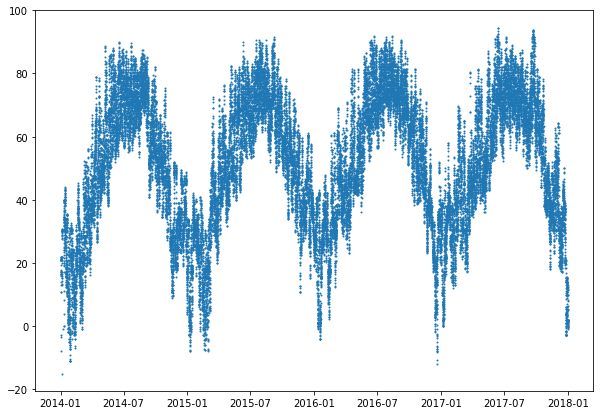

In [10]:
plt.figure(figsize=(10, 7))
plt.scatter(x=d['date'], y=d['temperature'], s=1)
plt.show()

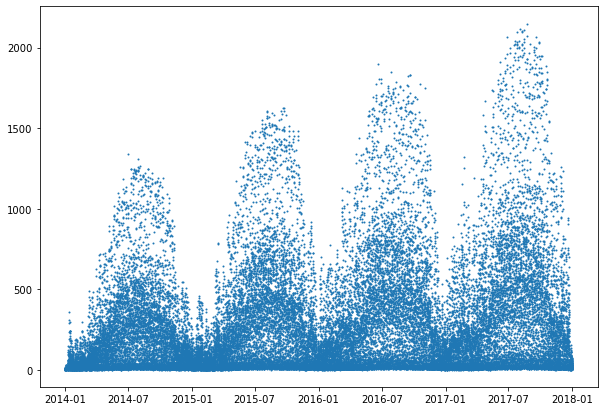

In [11]:
plt.figure(figsize=(10, 7))
plt.scatter(d.date, d.rides, s=1)
plt.show()

In [36]:
df = pd.DataFrame()
df['ds'] = d['date']
df['y'] = d['rides']
df['temp'] = d['temperature']
df = pd.concat([df, pd.get_dummies(d['weather'], drop_first=True)], axis=1)
# df['cap'] = 15000
# df['floor'] = 0

In [37]:
df.head()

,ds,y,temp,cloudy,not clear,rain or snow,tstorms,unknown
0,2014-01-01 01:00:00,1,10.9,0,1,0,0,0
1,2014-01-01 02:00:00,9,10.9,0,1,0,0,0
2,2014-01-01 03:00:00,4,13.0,0,1,0,0,0
3,2014-01-01 04:00:00,1,14.0,0,1,0,0,0
4,2014-01-01 07:00:00,2,16.1,0,0,1,0,0


In [38]:
df.tail()

,ds,y,temp,cloudy,not clear,rain or snow,tstorms,unknown
34711,2017-12-31 20:00:00,10,1.900,0,0,0,0,0
34712,2017-12-31 21:00:00,9,1.900,0,0,0,0,0
34713,2017-12-31 22:00:00,3,0.000,0,0,0,0,0
34714,2017-12-31 23:00:00,8,-0.225,0,0,0,0,0
34715,2018-01-01 00:00:00,5,-0.900,0,0,0,0,0


In [39]:
df.describe()

,y,temp,cloudy,not clear,rain or snow,tstorms,unknown
count,34716.000000,34716.000000,34716.000000,34716.000000,34716.000000,34716.000000,34716.000000
mean,273.511781,51.241300,0.795512,0.010629,0.096901,0.007633,0.000029
std,326.690929,20.695271,0.403333,0.102550,0.295827,0.087036,0.005367
min,1.000000,-15.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.000000,35.664567,1.000000,0.000000,0.000000,0.000000,0.000000
50%,155.000000,52.672934,1.000000,0.000000,0.000000,0.000000,0.000000
75%,397.000000,68.582418,1.000000,0.000000,0.000000,0.000000,0.000000
max,2149.000000,94.530645,1.000000,1.000000,1.000000,1.000000,1.000000


In [40]:
df[df['ds'] < pd.to_datetime('2017')].head()

,ds,y,temp,cloudy,not clear,rain or snow,tstorms,unknown
0,2014-01-01 01:00:00,1,10.9,0,1,0,0,0
1,2014-01-01 02:00:00,9,10.9,0,1,0,0,0
2,2014-01-01 03:00:00,4,13.0,0,1,0,0,0
3,2014-01-01 04:00:00,1,14.0,0,1,0,0,0
4,2014-01-01 07:00:00,2,16.1,0,0,1,0,0


In [41]:
m = Prophet()
m.add_country_holidays(country_name='US')
m.fit(df[d['date'] < pd.to_datetime('2017-01-01')])
future = m.make_future_dataframe(periods=365 * 24, freq='h')
forecast = m.predict(future)

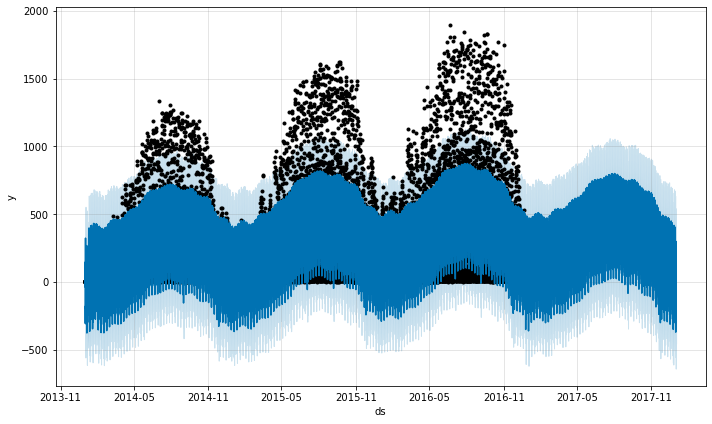

In [42]:
fig1 = m.plot(forecast)

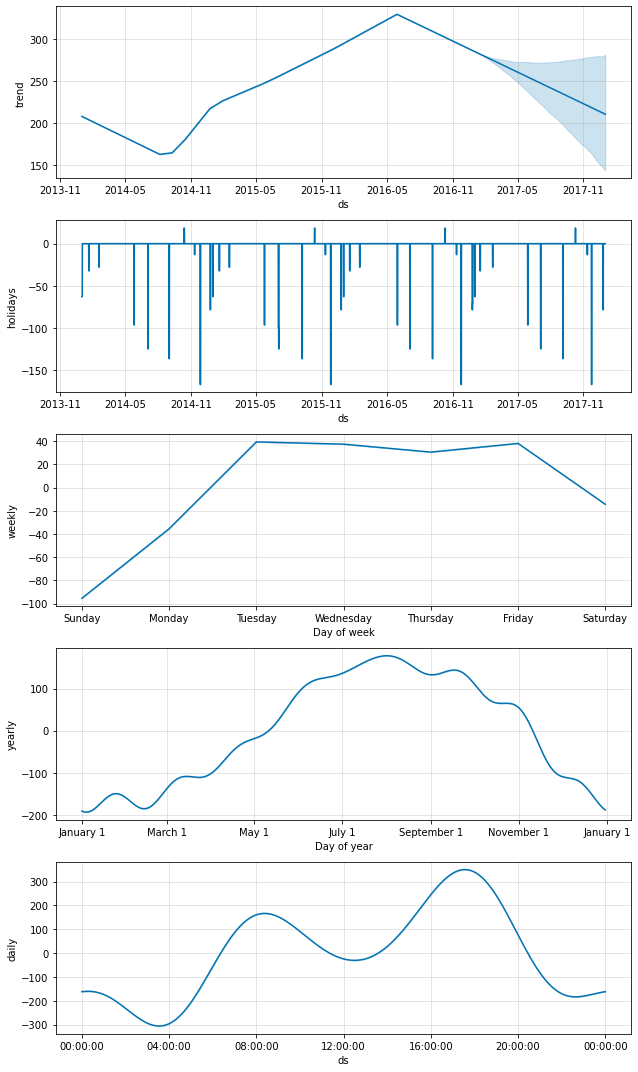

In [43]:
fig2 = m.plot_components(forecast)

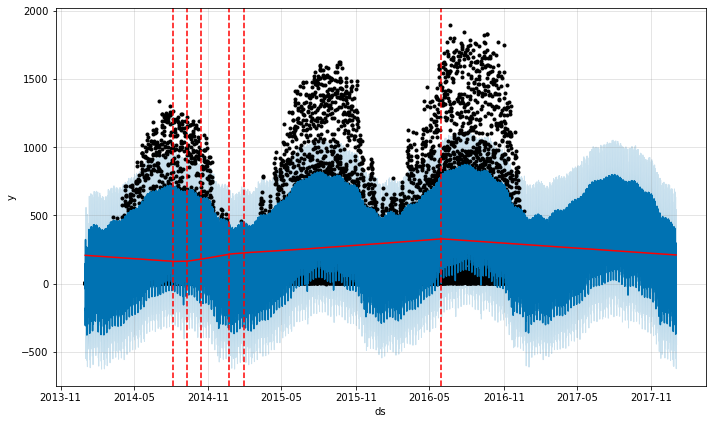

In [20]:
a = add_changepoints_to_plot(m.plot(forecast).gca(), m, forecast)

In [21]:
#dataframe of annual US Public Holidays over training and forecasting periods 

ny = pd.DataFrame({'holiday': "New Year's Day",
                   'ds' : pd.to_datetime(['2014-01-01',
                                          '2015-01-01',
                                          '2016-01-01',
                                          '2017-01-01',
                                          '2018-01-01',
                                          '2019-01-01'])})  
mlk = pd.DataFrame({'holiday': 'Birthday of Martin Luther King, Jr.',
                    'ds' : pd.to_datetime(['2014-01-20',
                                           '2015-01-19',
                                           '2016-01-18',
                                           '2017-01-16',
                                           '2018-01-15',
                                           '2019-01-21'])}) 
wash = pd.DataFrame({'holiday': "Washington's Birthday",
                     'ds' : pd.to_datetime(['2014-02-17',
                                            '2015-02-16',
                                            '2016-02-15',
                                            '2017-02-20',
                                            '2018-02-19',
                                            '2019-02-18'])})
mem = pd.DataFrame({'holiday': 'Memorial Day',
                    'ds' : pd.to_datetime(['2014-05-26',
                                           '2015-05-25',
                                           '2016-05-30',
                                           '2017-05-29',
                                           '2018-05-28',
                                           '2019-05-27'])})
ind = pd.DataFrame({'holiday': 'Independence Day',
                    'ds' : pd.to_datetime(['2014-07-04',
                                           '2015-07-04',
                                           '2016-07-04',
                                           '2017-07-04',
                                           '2018-07-04',
                                           '2019-07-04'])})
lab = pd.DataFrame({'holiday': 'Labor Day',
                    'ds' : pd.to_datetime(['2014-09-01',
                                           '2015-09-07',
                                           '2016-09-05',
                                           '2017-09-04',
                                           '2018-09-03',
                                           '2019-09-02'])})
col = pd.DataFrame({'holiday': 'Columbus Day',
                    'ds' : pd.to_datetime(['2014-10-13',
                                           '2015-10-12',
                                           '2016-10-10',
                                           '2017-10-09',
                                           '2018-10-08',
                                           '2019-10-14'])})
vet = pd.DataFrame({'holiday': "Veteran's Day",
                    'ds' : pd.to_datetime(['2014-11-11',
                                           '2015-11-11',
                                           '2016-11-11',
                                           '2017-11-11',
                                           '2018-11-11',
                                           '2019-11-11'])})
thanks = pd.DataFrame({'holiday': 'Thanksgiving Day',
                       'ds' : pd.to_datetime(['2014-11-27',
                                              '2015-11-26',
                                              '2016-11-24',
                                              '2017-11-23',
                                              '2018-11-22',
                                              '2019-11-28']),
                       'lower_window': 0,
                       'upper_window': 1})
christ = pd.DataFrame({'holiday': 'Christmas',
                       'ds' : pd.to_datetime(['2014-12-25',
                                              '2015-12-25',
                                              '2016-12-25',
                                              '2017-12-25',
                                              '2018-12-25',
                                              '2019-12-25']),
                       'lower_window': -1,
                       'upper_window': 0})

holidays = pd.concat([ny, mlk, wash, mem, ind, lab, col, vet, thanks, christ], sort=False)

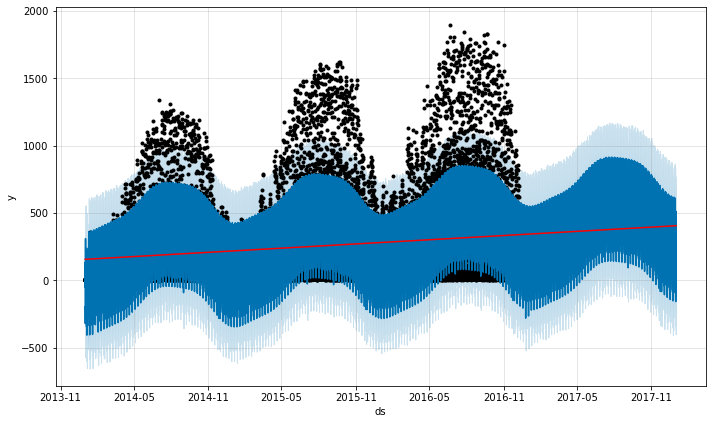

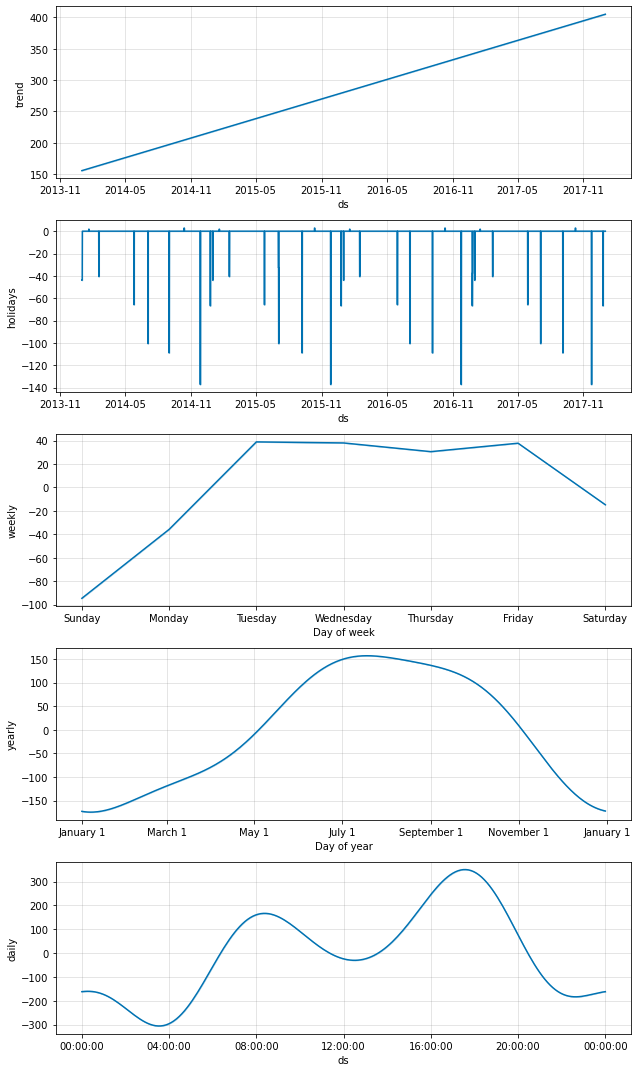

INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-01-01 23:00:00 and 2016-01-01 23:00:00


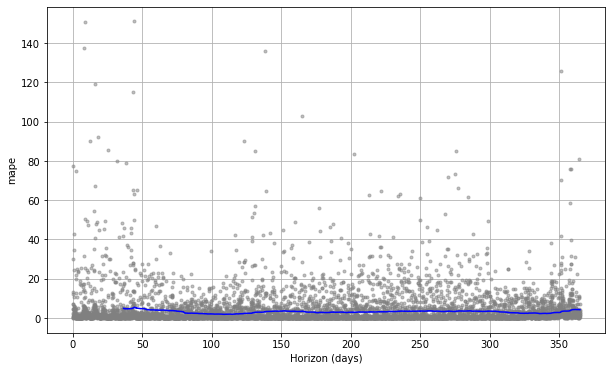

mape: 314.90%


In [22]:
prophet = Prophet(yearly_seasonality=False,
                  changepoint_prior_scale=.001).add_seasonality(name='yearly',
                                    period=365.25,
                                    fourier_order=3,
                                    prior_scale=10,
                                    mode='additive')


prophet.add_country_holidays(country_name='US')
prophet.fit(df[df['ds'] < pd.to_datetime('2017')])
future = prophet.make_future_dataframe(periods=365 * 24, freq='H')



forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()
df_cv = cross_validation(prophet, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()
print('mape:', '{:.2f}%'.format(100 * df_p['mape'].mean()))

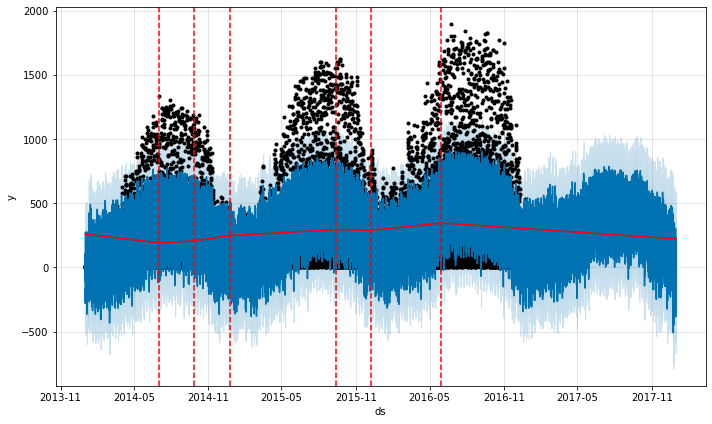

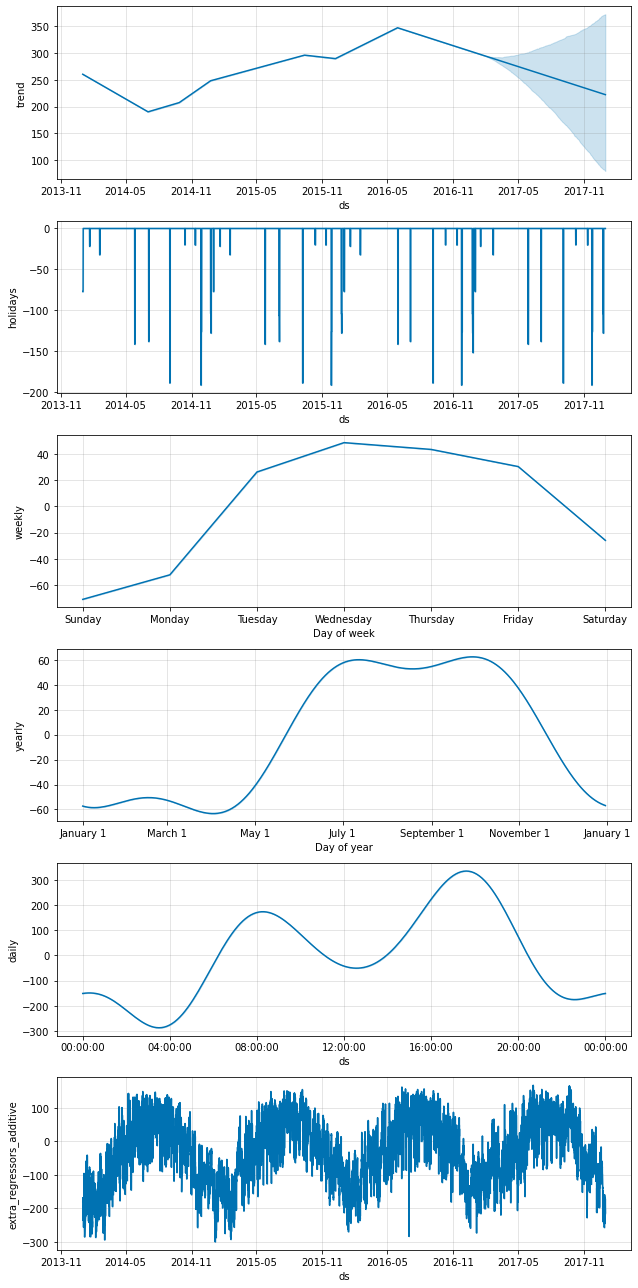

INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-01-01 23:00:00 and 2016-01-01 23:00:00


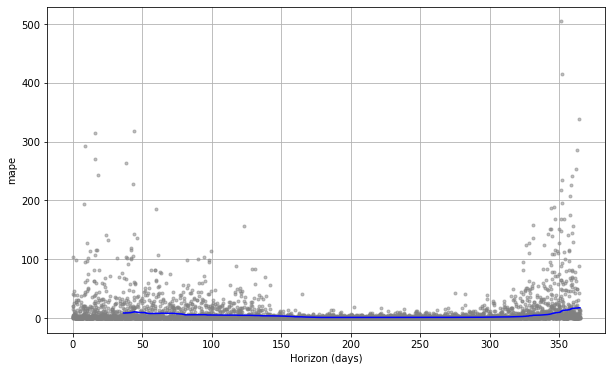

mape: 385.86%


In [23]:
prophet = Prophet(growth='linear',
                  n_changepoints=10,
                  yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  holidays=holidays,
                  seasonality_mode='additive',
                  seasonality_prior_scale=10,
                  holidays_prior_scale=10,
                  changepoint_prior_scale=.05,
                  mcmc_samples=0
                 ).add_seasonality(name='yearly',
                                    period=365.25,
                                    fourier_order=3,
                                    prior_scale=10,
                                    mode='additive'
                  ).add_seasonality(name='weekly',
                                    period=7,
                                    fourier_order=5,
                                    prior_scale=10,
                                    mode='additive'
                  ).add_seasonality(name='daily',
                                    period=1,
                                    fourier_order=4,
                                    prior_scale=.10,
                                    mode='additive'
                  )

prophet.add_country_holidays(country_name='US')

prophet.add_regressor('temp')
prophet.add_regressor('cloudy')
prophet.add_regressor('not clear')
prophet.add_regressor('rain or snow')
prophet.add_regressor('tstorms')
prophet.add_regressor('unknown')

prophet.fit(df[df['ds'] < pd.to_datetime('2017')])
future = prophet.make_future_dataframe(periods=365 * 24, freq='H')

future['temp'] = df['temp']
future['cloudy'] = df['cloudy']
future['not clear'] = df['not clear']
future['rain or snow'] = df['rain or snow']
future['tstorms'] = df['tstorms']
future['unknown'] = df['unknown']

future.dropna(inplace=True)

forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()
df_cv = cross_validation(prophet, initial='730 days', period='180 days', horizon='365 days')
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()
print('mape:', '{:.2f}%'.format(100 * df_p['mape'].mean()))

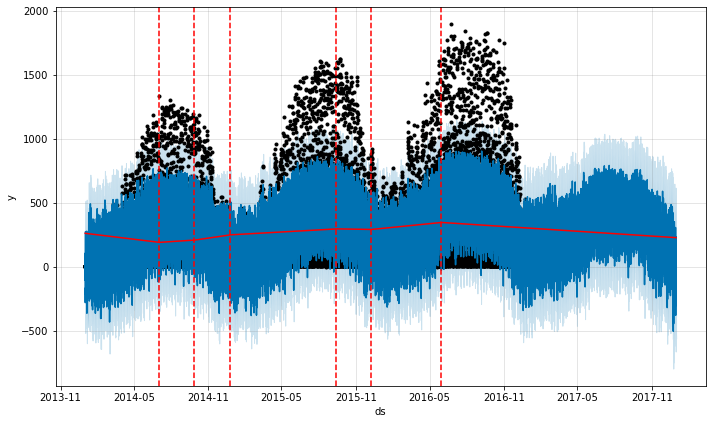

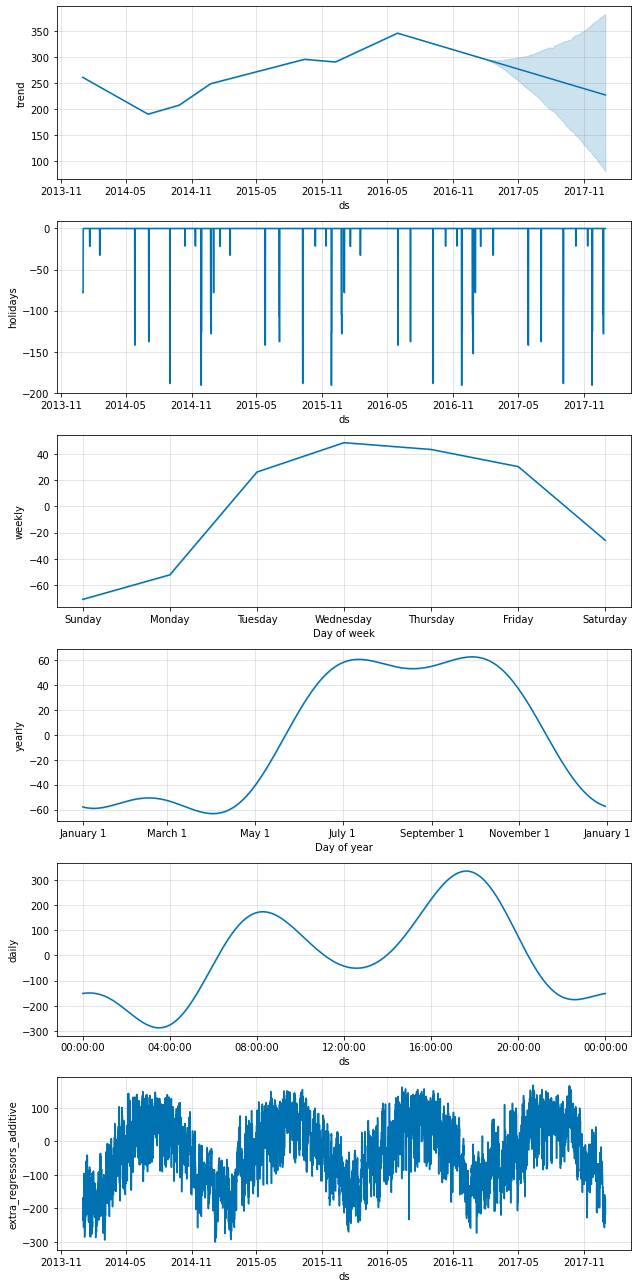

INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-01-01 23:00:00 and 2016-01-01 23:00:00


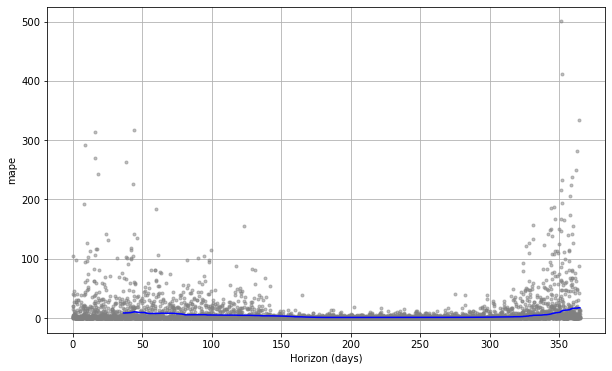

mape: 382.14%


In [24]:
prophet = Prophet(growth='linear',
                  n_changepoints=10,
                  yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  holidays=holidays,
                  seasonality_mode='additive',
                  seasonality_prior_scale=10,
                  holidays_prior_scale=10,
                  changepoint_prior_scale=.05,
                  mcmc_samples=0
                 ).add_seasonality(name='yearly',
                                    period=365.25,
                                    fourier_order=3,
                                    prior_scale=10,
                                    mode='additive'
                  ).add_seasonality(name='weekly',
                                    period=7,
                                    fourier_order=5,
                                    prior_scale=.1,
                                    mode='additive'
                  ).add_seasonality(name='daily',
                                    period=1,
                                    fourier_order=4,
                                    prior_scale=.1,
                                    mode='additive'
                  )

prophet.add_country_holidays(country_name='US')

prophet.add_regressor('temp')
prophet.add_regressor('cloudy')
prophet.add_regressor('not clear')
prophet.add_regressor('rain or snow')
prophet.add_regressor('tstorms')
prophet.add_regressor('unknown')

prophet.fit(df[df['ds'] < pd.to_datetime('2017')])
future = prophet.make_future_dataframe(periods=365 * 24, freq='H')

future['temp'] = df['temp']
future['cloudy'] = df['cloudy']
future['not clear'] = df['not clear']
future['rain or snow'] = df['rain or snow']
future['tstorms'] = df['tstorms']
future['unknown'] = df['unknown']

future.dropna(inplace=True)

forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()
df_cv = cross_validation(prophet, initial='730 days', period='180 days', horizon='365 days')
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()
print('mape:', '{:.2f}%'.format(100 * df_p['mape'].mean()))

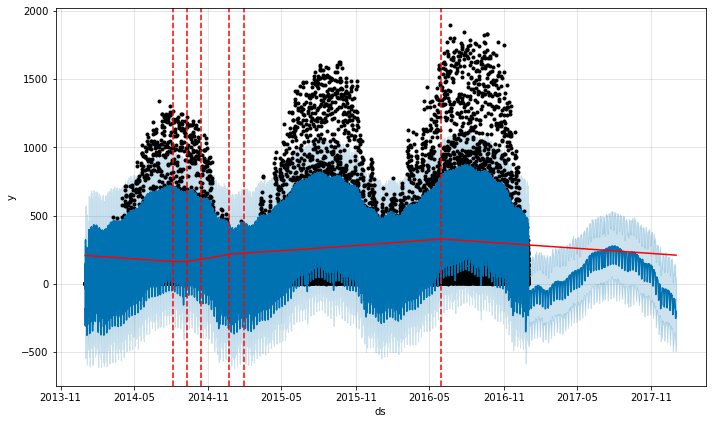

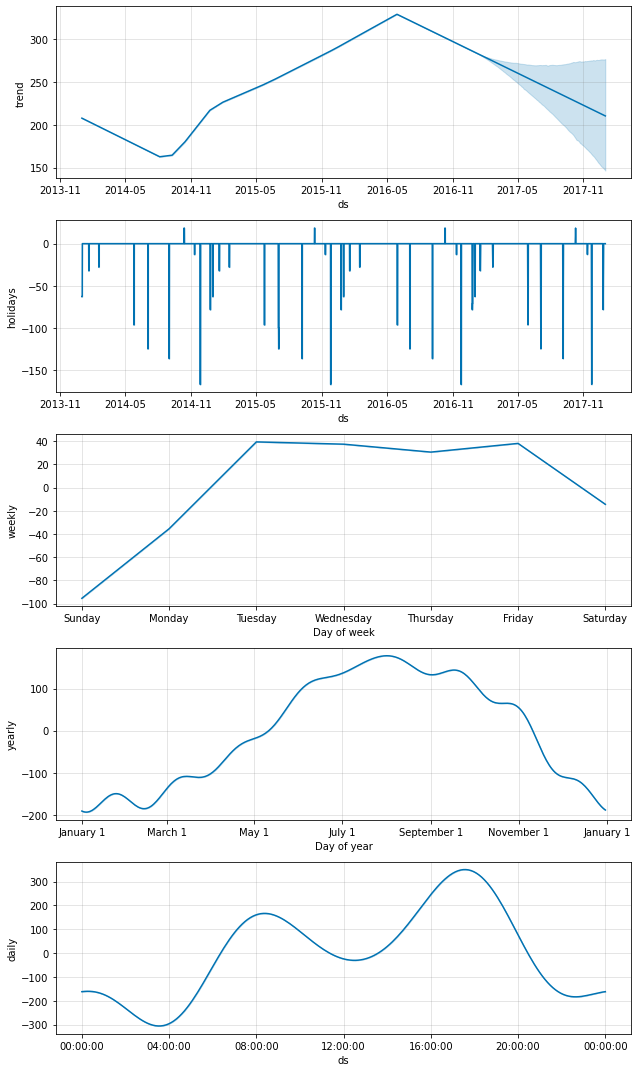

INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-01-01 23:00:00 and 2016-01-01 23:00:00


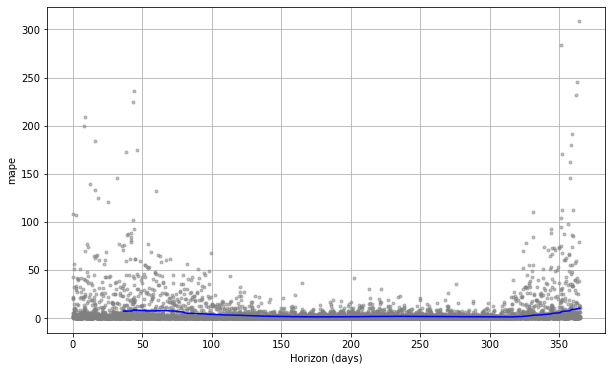

mape: 299.40%


In [25]:
prophet = Prophet()
prophet.add_country_holidays(country_name='US')
prophet.fit(df[df['ds'] < pd.to_datetime('2017')])
future = prophet.make_future_dataframe(periods=365, freq='D')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()
df_cv = cross_validation(prophet, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()
print('mape:', '{:.2f}%'.format(100 * df_p['mape'].mean()))

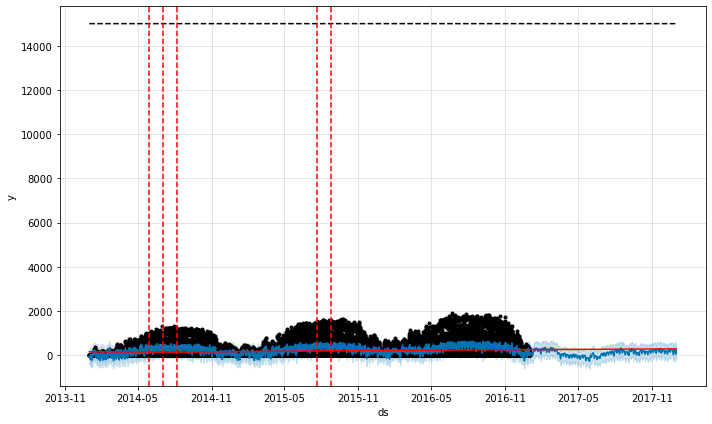

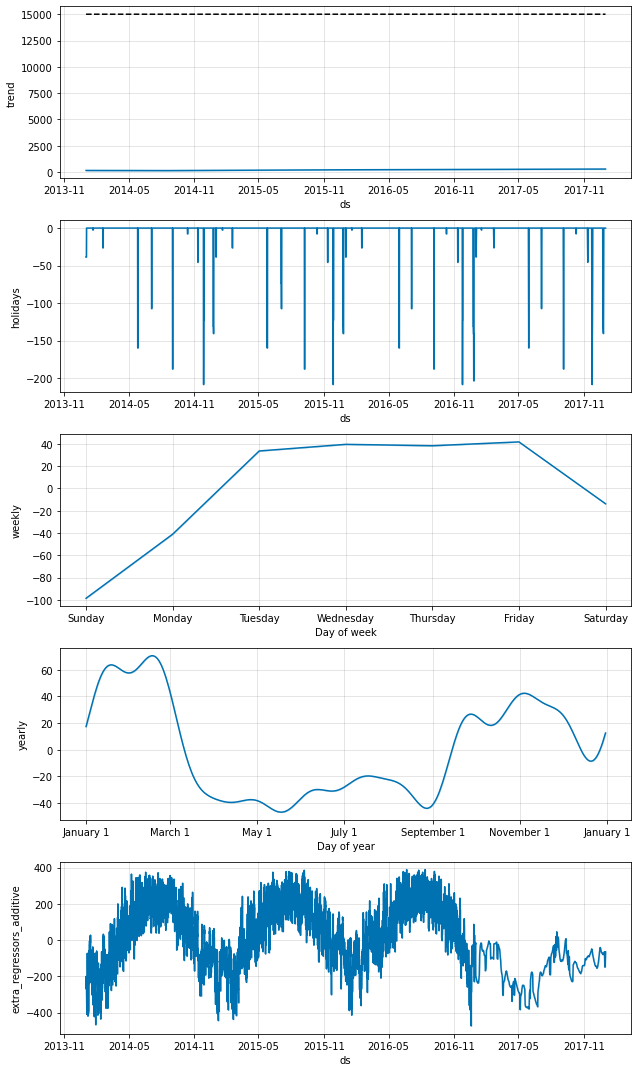

INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-01-01 23:00:00 and 2016-01-01 23:00:00


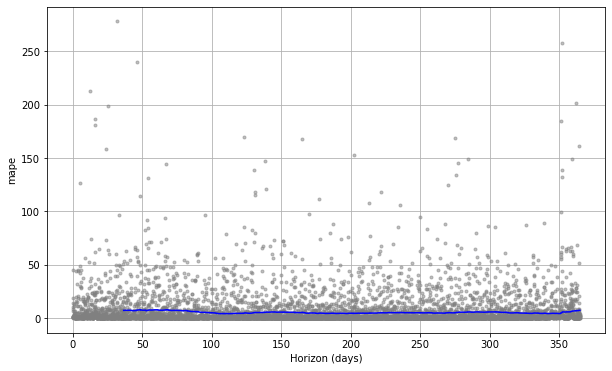

mape: 524.11%


In [26]:
prophet = Prophet(growth='linear',
                  n_changepoints=25,
                  changepoint_range=0.8,
                  yearly_seasonality=True,
                  weekly_seasonality=True,
                  daily_seasonality=False,
                  holidays=holidays,
                  seasonality_mode='additive',
                  seasonality_prior_scale=10,
                  holidays_prior_scale=10,
                  changepoint_prior_scale=.01,
                  mcmc_samples=0)
prophet.add_country_holidays(country_name='US')
prophet.add_regressor('temp', mode='additive')
prophet.add_regressor('cloudy', mode='additive')
prophet.add_regressor('not clear', mode='additive')
prophet.add_regressor('rain or snow', mode='additive')
prophet.fit(df[df['ds'] < pd.to_datetime('2017')])
future = prophet.make_future_dataframe(periods=365, freq='D')
future['temp'] = df['temp']
future['cloudy'] = df['cloudy']
future['not clear'] = df['not clear']
future['rain or snow'] = df['rain or snow']
future['cap'] = df['cap']
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()
df_cv = cross_validation(prophet, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()
print('mape:', '{:.2f}%'.format(100 * df_p['mape'].mean()))

In [44]:
def is_weekend(ds):
    date = pd.to_datetime(ds)
    return (date.dayofweek == 5 or date.dayofweek == 6)

df['weekend'] = df['ds'].apply(is_weekend)
df['weekday'] = ~df['ds'].apply(is_weekend)

In [45]:
df.head()

,ds,y,temp,cloudy,not clear,rain or snow,tstorms,unknown,weekend,weekday
0,2014-01-01 01:00:00,1,10.9,0,1,0,0,0,False,True
1,2014-01-01 02:00:00,9,10.9,0,1,0,0,0,False,True
2,2014-01-01 03:00:00,4,13.0,0,1,0,0,0,False,True
3,2014-01-01 04:00:00,1,14.0,0,1,0,0,0,False,True
4,2014-01-01 07:00:00,2,16.1,0,0,1,0,0,False,True


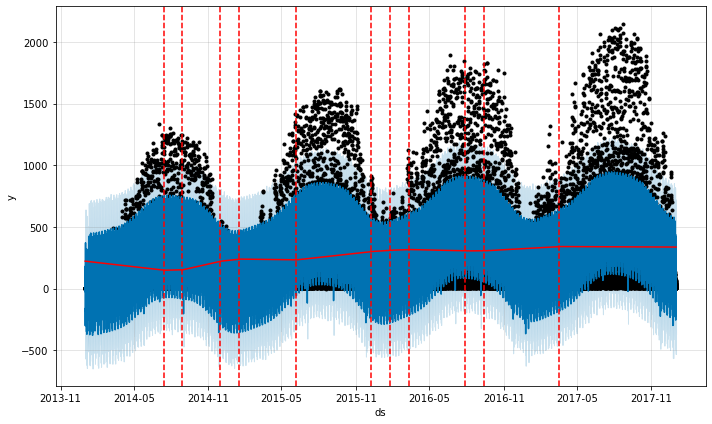

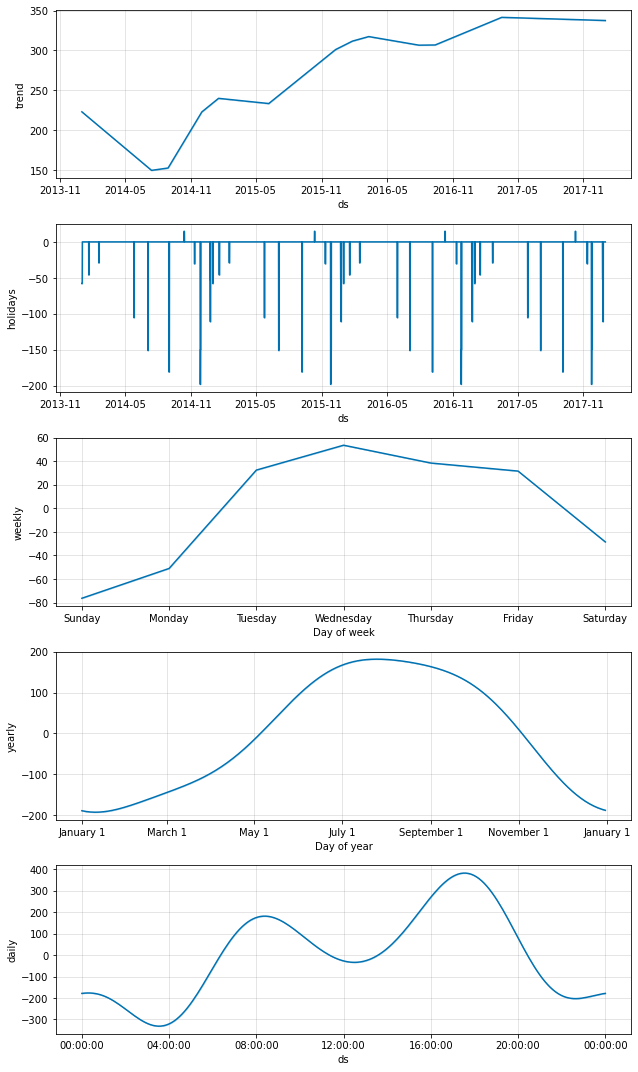

In [46]:
prophet = Prophet(growth='linear',
                  yearly_seasonality=3,
                  weekly_seasonality=5,
                  daily_seasonality=4,
                  holidays=holidays,
                  seasonality_mode='additive',
                  seasonality_prior_scale=10,
                  holidays_prior_scale=10,
                  changepoint_prior_scale=.05,
                  mcmc_samples=0)

future['weekend'] = future['ds'].apply(is_weekend)
future['weekday'] = ~future['ds'].apply(is_weekend)
forecast = prophet.fit(df).predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()

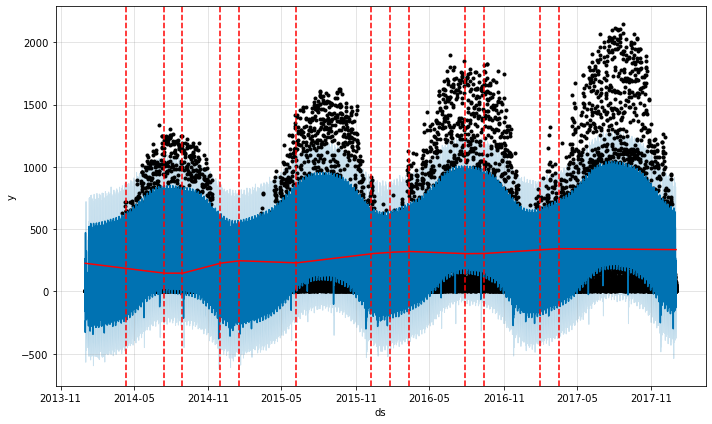

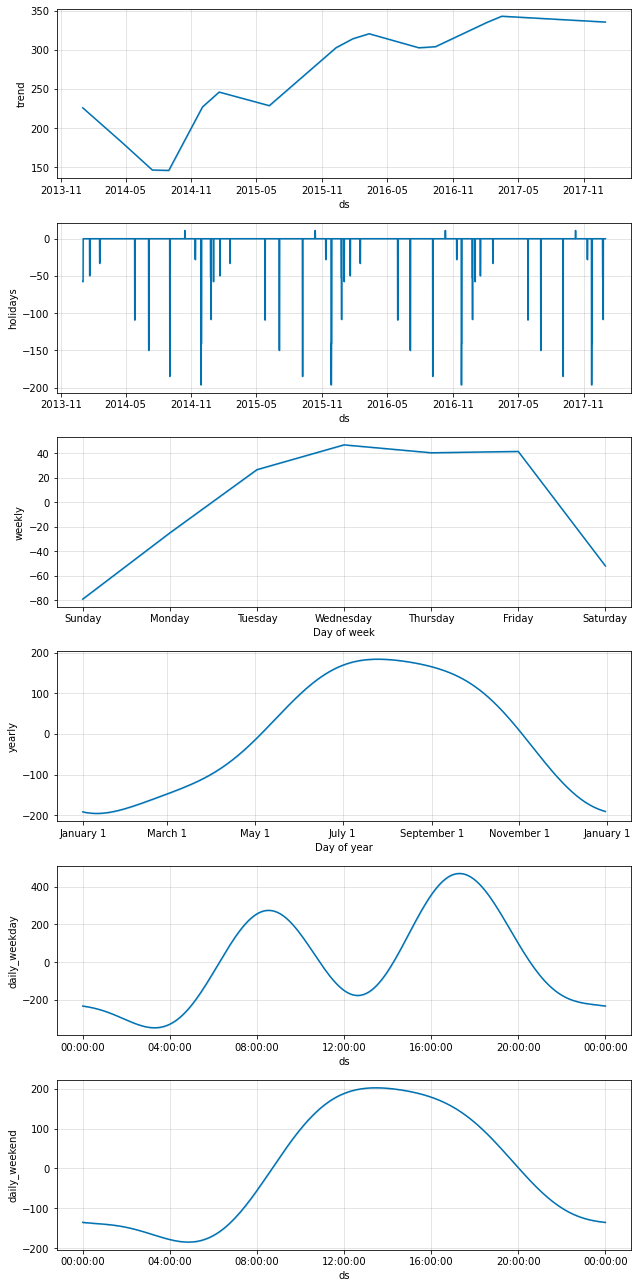

In [50]:
prophet = Prophet(growth='linear',
                  yearly_seasonality=3,
                  weekly_seasonality=5,
                  daily_seasonality=False,
                  holidays=holidays,
                  seasonality_mode='additive',
                  seasonality_prior_scale=10,
                  holidays_prior_scale=10,
                  changepoint_prior_scale=.05,
                  mcmc_samples=0)
prophet.add_seasonality(name='daily_weekend', period=1, fourier_order=3, condition_name='weekend')
prophet.add_seasonality(name='daily_weekday', period=1, fourier_order=3, condition_name='weekday')

future['weekend'] = future['ds'].apply(is_weekend)
future['weekday'] = ~future['ds'].apply(is_weekend)
forecast = prophet.fit(df).predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()

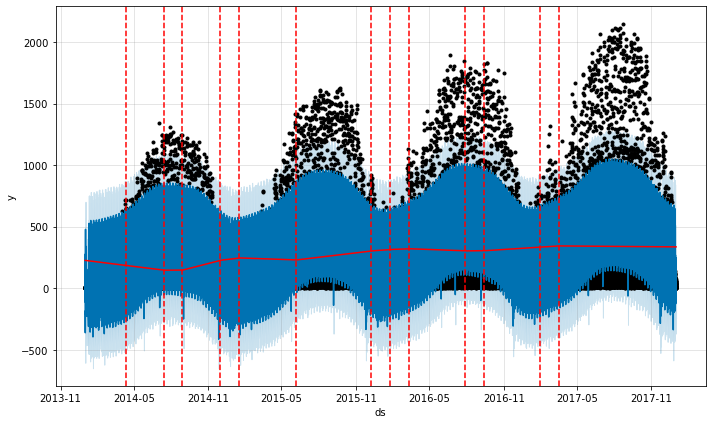

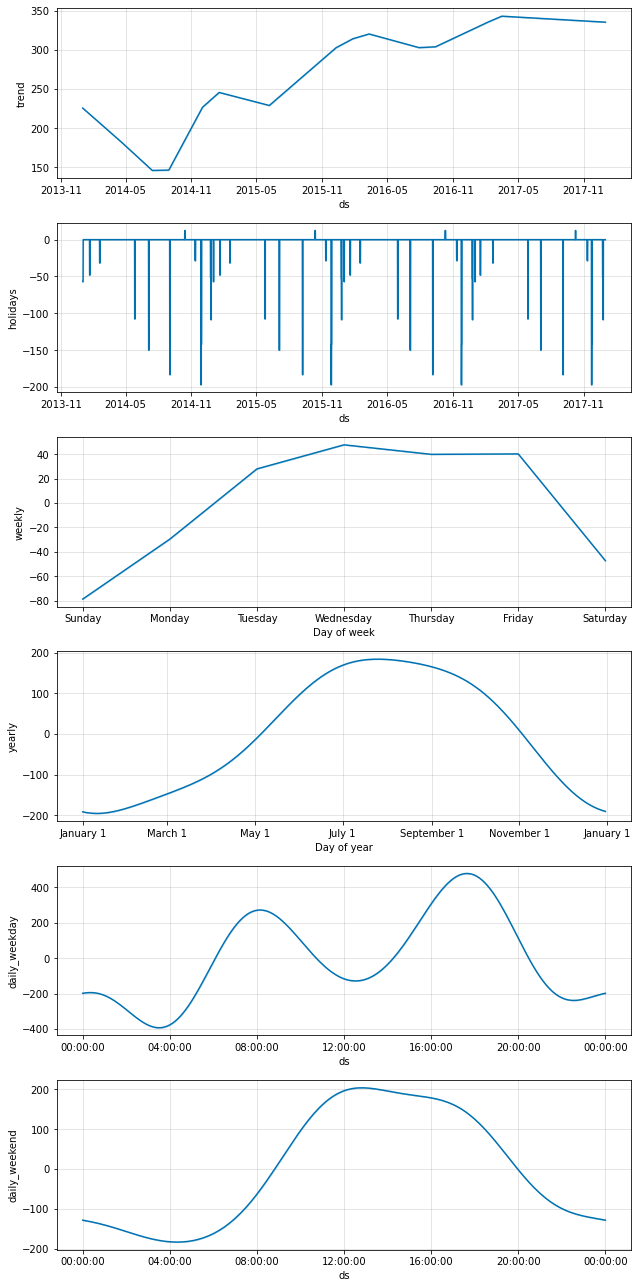

In [51]:
prophet = Prophet(growth='linear',
                  yearly_seasonality=3,
                  weekly_seasonality=5,
                  daily_seasonality=False,
                  holidays=holidays,
                  seasonality_mode='additive',
                  seasonality_prior_scale=10,
                  holidays_prior_scale=10,
                  changepoint_prior_scale=.05,
                  mcmc_samples=0)
prophet.add_seasonality(name='daily_weekend', period=1, fourier_order=4, condition_name='weekend')
prophet.add_seasonality(name='daily_weekday', period=1, fourier_order=4, condition_name='weekday')

future['weekend'] = future['ds'].apply(is_weekend)
future['weekday'] = ~future['ds'].apply(is_weekend)
forecast = prophet.fit(df).predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()